<a href="https://colab.research.google.com/github/HamorHam/IAT_360-Fine-tune-NLP-model/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Project Introduction: Sentiment Analysis Fine-Tuning on Tweet Data

This project focuses on fine-tuning the pre-trained cardiffnlp/twitter-roberta-base model using a custom dataset for sentiment analysis.

# Step 1: Load Custom Dataset

In [1]:
# Link to google drive
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


##Load the dataset from google drive into a compatible format

In [ ]:
import pandas as pd

def load_dataset(file_path):
    data = pd.read_csv(file_path, sep=';', header=None, names=['text', 'label'])
    return data

train_data = load_dataset("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/train.txt")
val_data = load_dataset("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/val.txt")
test_data = load_dataset("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/test.txt")

# Step 2: Map Labels

## Map the dataset's emotion labels to integers

In [ ]:
label_mapping = {
    'sadness': 0,
    'joy': 1,
    'fear': 2,
    'anger': 3,
    'surprise': 4,
    'love': 5
}

train_data['label'] = train_data['label'].map(label_mapping)
val_data['label'] = val_data['label'].map(label_mapping)
test_data['label'] = test_data['label'].map(label_mapping)

# Step 3: data preprocessing

## Visualize the data balance before tokenizing the dataset

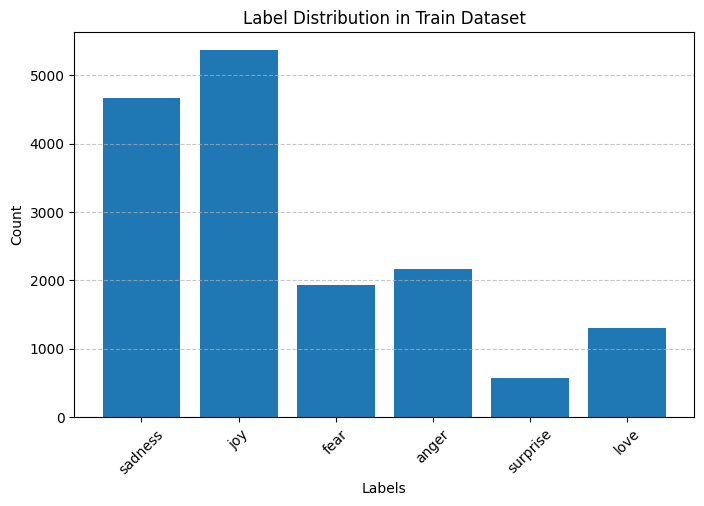

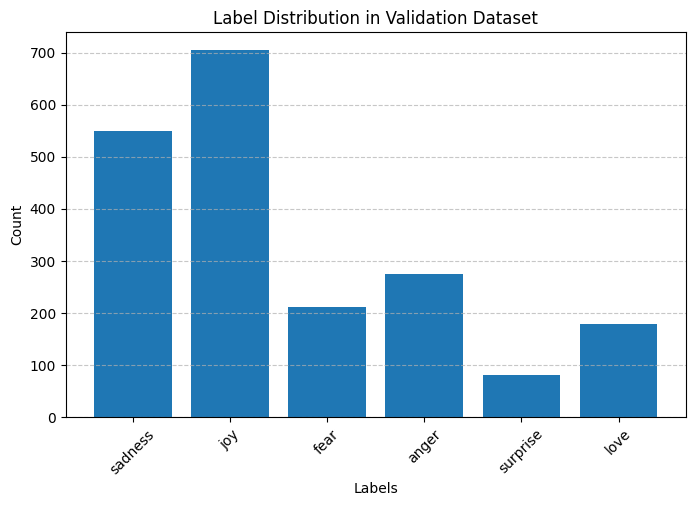

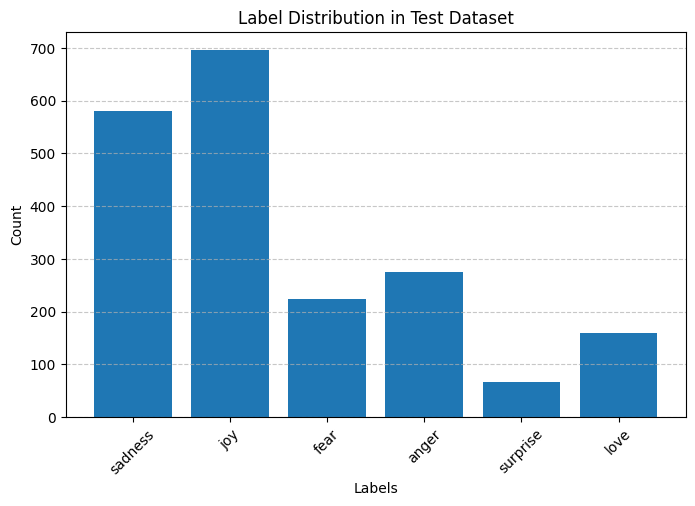

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(data, dataset_name):
    # Ensure all labels are included even if some have 0 instances
    label_counts = data['label'].value_counts().reindex(range(6), fill_value=0)
    labels = ['sadness', 'joy', 'fear', 'anger', 'surprise', 'love']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, label_counts)
    plt.title(f'Label Distribution in {dataset_name} Dataset')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot for each dataset
plot_label_distribution(train_data, 'Train')
plot_label_distribution(val_data, 'Validation')
plot_label_distribution(test_data, 'Test')


As the chart shows the data set is not balanced. In order to balance the datasets using undersampling, we can reduce the number of samples for overrepresented classes to match the size of the smallest class.

In [ ]:
!pip install imbalanced-learn


Before Undersampling:
Train: Counter({1: 5362, 0: 4666, 3: 2159, 2: 1937, 5: 1304, 4: 572})
Validation: Counter({1: 704, 0: 550, 3: 275, 2: 212, 5: 178, 4: 81})
Test: Counter({1: 695, 0: 581, 3: 275, 2: 224, 5: 159, 4: 66})

After Undersampling:
Train: Counter({0: 572, 1: 572, 2: 572, 3: 572, 4: 572, 5: 572})
Validation: Counter({0: 81, 1: 81, 2: 81, 3: 81, 4: 81, 5: 81})
Test: Counter({0: 66, 1: 66, 2: 66, 3: 66, 4: 66, 5: 66})


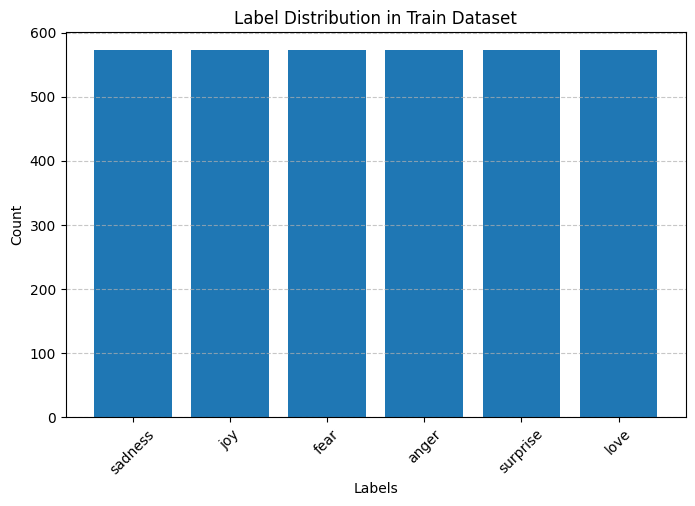

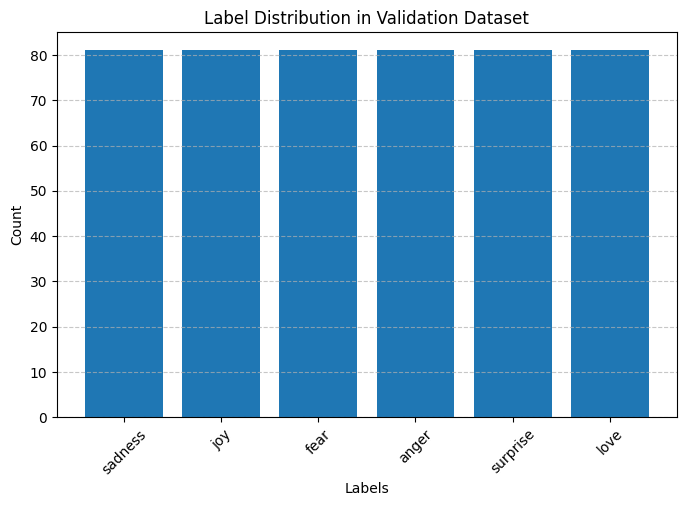

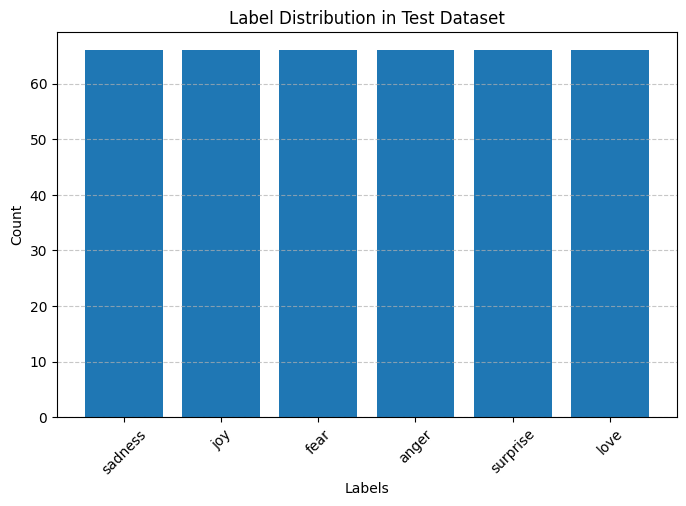

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def undersample_data(data):
    """
    Balances the dataset by undersampling the overrepresented classes.

    Args:
        data: Pandas DataFrame containing 'text' and 'label' columns.

    Returns:
        Balanced Pandas DataFrame.
    """
    # Separate features and labels
    X = data['text'].values.reshape(-1, 1)  # Reshape to 2D array for sampler
    y = data['label']

    # Initialize RandomUnderSampler
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Recreate a balanced DataFrame
    balanced_data = pd.DataFrame({
        'text': X_resampled.flatten(),
        'label': y_resampled
    })

    return balanced_data

# Apply undersampling to each dataset
train_data_balanced = undersample_data(train_data)
val_data_balanced = undersample_data(val_data)
test_data_balanced = undersample_data(test_data)

# Print class distribution before and after
print("Before Undersampling:")
print("Train:", Counter(train_data['label']))
print("Validation:", Counter(val_data['label']))
print("Test:", Counter(test_data['label']))

print("\nAfter Undersampling:")
print("Train:", Counter(train_data_balanced['label']))
print("Validation:", Counter(val_data_balanced['label']))
print("Test:", Counter(test_data_balanced['label']))

# Plot for each dataset
plot_label_distribution(train_data_balanced, 'Train')
plot_label_distribution(val_data_balanced, 'Validation')
plot_label_distribution(test_data_balanced, 'Test')

# Step 4: Tokenize the Dataset

Use the tokenizer from the cardiffnlp/twitter-roberta-base model to tokenize the text data.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")

def tokenize_data(data):
    return tokenizer(
        data['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = tokenize_data(train_data_balanced)
val_encodings = tokenize_data(val_data_balanced)
test_encodings = tokenize_data(test_data_balanced)

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

#Step 5: Prepare the Dataset for PyTorch

In [ ]:
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        """
        Args:
            encodings: Tokenized inputs (input_ids, attention_mask).
            labels: List or tensor of corresponding labels.
        """
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        # Returns the number of samples
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Fetches a single item by index.
        Args:
            idx: Index of the sample.
        Returns:
            Dictionary containing input_ids, attention_mask, and labels.
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
train_dataset = CustomDataset(train_encodings, train_data_balanced['label'].tolist())
val_dataset = CustomDataset(val_encodings, val_data_balanced['label'].tolist())
test_dataset = CustomDataset(test_encodings, test_data_balanced['label'].tolist())

# Check dataset size
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Train Dataset Size: 3432
Validation Dataset Size: 486
Test Dataset Size: 396


# Step 6: Fine-Tune the Model

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base",
    num_labels=len(label_mapping)
)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-38-ca351cba5ded>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather tha

Epoch,Training Loss,Validation Loss
1,0.523800,0.418028
2,0.233300,0.293672
3,0.146200,0.335831
4,0.152500,0.301676
5,0.057300,0.301211
6,0.100900,0.348669
7,0.065200,0.311522
8,0.038400,0.336524
9,0.014000,0.374977
10,0.015000,0.362719


<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct fro

TrainOutput(global_step=2150, training_loss=0.21638200644403696, metrics={'train_runtime': 565.035, 'train_samples_per_second': 60.74, 'train_steps_per_second': 3.805, 'total_flos': 1252248040105920.0, 'train_loss': 0.21638200644403696, 'epoch': 10.0})

# Step 7: Evaluate the Model

<ipython-input-39-561f78ecc01c>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.4655664563179016, 'eval_model_preparation_time': 0.0035, 'eval_accuracy': 0.9191919191919192, 'eval_f1': 0.9190544448032321, 'eval_precision': 0.9206240136339037, 'eval_recall': 0.9191919191919192, 'eval_runtime': 1.3036, 'eval_samples_per_second': 303.774, 'eval_steps_per_second': 19.178}
Evaluation Metrics:
loss: 0.4656
model_preparation_time: 0.0035
accuracy: 0.9192
f1: 0.9191
precision: 0.9206
recall: 0.9192
runtime: 1.3036
samples_per_second: 303.7740
steps_per_second: 19.1780


<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


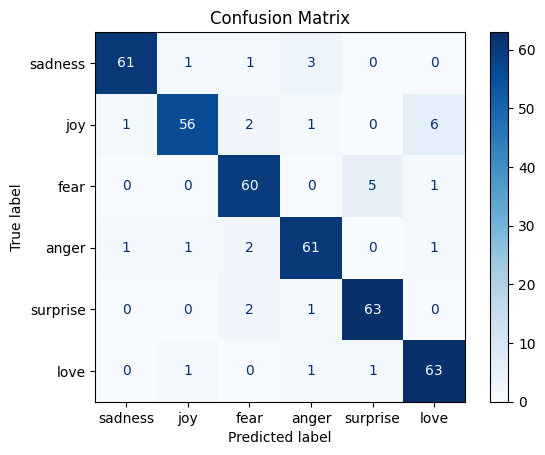

In [ ]:
!pip install scikit-learn
#Define a function that computes accuracy, F1 score, precision, and recall using scikit-learn.
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Get the class with the highest logit
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")  # Weighted F1 for imbalanced datasets
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }
#Pass the custom metrics function to the Trainer.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#SHow the evaluation
results = trainer.evaluate(test_dataset)
print(results)

# Display the results
print("Evaluation Metrics:")
for metric, value in results.items():
    if metric.startswith("eval_"):
        print(f"{metric[5:]}: {value:.4f}")

# Get predictions from the test dataset
predictions = trainer.predict(test_dataset)
logits, labels = predictions.predictions, predictions.label_ids
predicted_labels = logits.argmax(axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 8: Save the Model

In [ ]:

model.save_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned")
tokenizer.save_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned")

('/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned/tokenizer_config.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned/special_tokens_map.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned/vocab.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned/merges.txt',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned/added_tokens.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned/tokenizer.json')

# Step 9: Build a pipeline and make predictions with fine-tuned model

In [ ]:
#Load the Fine-Tuned Model and Tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load the fine-tuned model and tokenizer
model_path = "/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create a sentiment analysis pipeline
sentiment_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Step 10: Make Predictions

In [ ]:
texts = [
    "I feel so happy and grateful today!",
    "This is the worst day of my life.",
    "I am feeling anxious about the future."
]

# Get predictions
predictions = sentiment_pipeline(texts)

# Print the results
for text, pred in zip(texts, predictions):
    print(f"Text: {text}\nPrediction: {pred}\n")

# Reverse label mapping
reverse_label_mapping = {0: "sadness", 1: "joy", 2: "fear", 3: "anger", 4: "surprise", 5: "love"}

# Convert predictions
for text, pred in zip(texts, predictions):
    label = reverse_label_mapping[int(pred['label'].split('_')[-1])]  # Extract numeric label
    print(f"Text: {text}\nPredicted Sentiment: {label}, Confidence: {pred['score']:.4f}\n")

Text: I feel so happy and grateful today!
Prediction: {'label': 'LABEL_1', 'score': 0.9993448853492737}

Text: This is the worst day of my life.
Prediction: {'label': 'LABEL_0', 'score': 0.9961680769920349}

Text: I am feeling anxious about the future.
Prediction: {'label': 'LABEL_2', 'score': 0.9992557168006897}

Text: I feel so happy and grateful today!
Predicted Sentiment: joy, Confidence: 0.9993

Text: This is the worst day of my life.
Predicted Sentiment: sadness, Confidence: 0.9962

Text: I am feeling anxious about the future.
Predicted Sentiment: fear, Confidence: 0.9993



# Change one hyperparameter to see if the model's performance increase

##Modify the Batch Size (16 -> 32)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # Increased batch size
    per_device_eval_batch_size=32,  # Adjusted evaluation batch size
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
)
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-29-3a2d24ee3aa7>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.037700,0.490453
2,0.036600,0.588644
3,0.024100,0.540569
4,0.028000,0.560428
5,0.012000,0.514943
6,0.050900,0.572914
7,0.011000,0.539680
8,0.005600,0.561886
9,0.000300,0.566148
10,0.044500,0.564711


<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct fro

TrainOutput(global_step=1080, training_loss=0.025699927671855593, metrics={'train_runtime': 549.9678, 'train_samples_per_second': 62.404, 'train_steps_per_second': 1.964, 'total_flos': 1252248040105920.0, 'train_loss': 0.025699927671855593, 'epoch': 10.0})

<ipython-input-36-9d051919dfcf>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Metrics:
loss: 0.6315
model_preparation_time: 0.0056
accuracy: 0.9066
f1: 0.9062
precision: 0.9078
recall: 0.9066
runtime: 1.2975
samples_per_second: 305.2140
steps_per_second: 10.0200


<ipython-input-19-dad45323e1ef>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


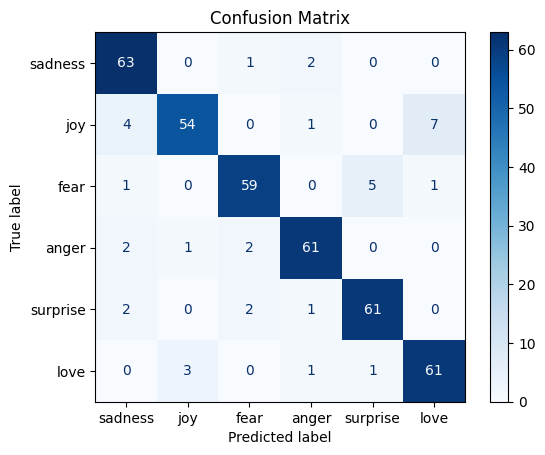

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import Trainer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Get the class with the highest logit
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")  # Weighted F1 for imbalanced datasets
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

# Initialize the Trainer with the custom metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Evaluate the model on the test dataset
results = trainer.evaluate(eval_dataset=test_dataset)

# Display the results
print("Evaluation Metrics:")
for metric, value in results.items():
    if metric.startswith("eval_"):
        print(f"{metric[5:]}: {value:.4f}")

# Get predictions from the test dataset
predictions = trainer.predict(test_dataset)
logits, labels = predictions.predictions, predictions.label_ids
predicted_labels = logits.argmax(axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#Save the New Model

In [ ]:
model.save_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned")
tokenizer.save_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned")

('/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned/tokenizer_config.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned/special_tokens_map.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned/vocab.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned/merges.txt',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned/added_tokens.json',
 '/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned/tokenizer.json')

# Test the both model performance with AI generated data

##Base Model (16 batch)

In [2]:
import pandas as pd

# Load test.txt
test_file_path = "/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Testset.txt"

# Read the file into a DataFrame
test_data = pd.read_csv(test_file_path, sep=';', header=None, names=['text', 'label'])

# Map labels to numeric values (ensure this matches your training label mapping)
label_mapping = {
    'sadness': 0,
    'joy': 1,
    'fear': 2,
    'anger': 3,
    'surprise': 4,
    'love': 5
}
test_data['label'] = test_data['label'].map(label_mapping)

from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned")

# Tokenize the test text
test_encodings = tokenizer(
    test_data['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

import torch

class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

test_dataset = CustomTestDataset(test_encodings, test_data['label'].tolist())

from transformers import AutoModelForSequenceClassification, Trainer

# Load the fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model/tweet_eval_finetuned")

# Define the Trainer with the model
trainer = Trainer(
    model=model,
    tokenizer=tokenizer
)

# Evaluate the model on the test dataset
results = trainer.evaluate(eval_dataset=test_dataset)

# Print the evaluation metrics
print("Evaluation Metrics:")
for metric, value in results.items():
    if metric.startswith("eval_"):
        print(f"{metric[5:]}: {value:.4f}")

<ipython-input-2-2123b7d2ec9c>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Evaluation Metrics:
loss: 1.3032
model_preparation_time: 0.0038
runtime: 13.7968
samples_per_second: 8.6980
steps_per_second: 1.0870


Predict the sentiment for each sentence in the test file:

In [3]:
# Get predictions
predictions = trainer.predict(test_dataset)
logits, labels = predictions.predictions, predictions.label_ids
predicted_labels = logits.argmax(axis=-1)

# Map numeric predictions back to their labels
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_data['predicted_label'] = [reverse_label_mapping[label] for label in predicted_labels]

# Display some predictions
print(test_data[['text', 'label', 'predicted_label']].head())

                                                text  label predicted_label
0  Just got a surprise promotion I NEVER saw coming!      4             joy
1  Another birthday alone. Wondering if I'll ever...      0             joy
2  Politicians continue to fail us. WHEN WILL THI...      3         sadness
3  Medical test results coming in. Anxiety is thr...      2            fear
4      Married my best friend today. Soulmate found!      5            love


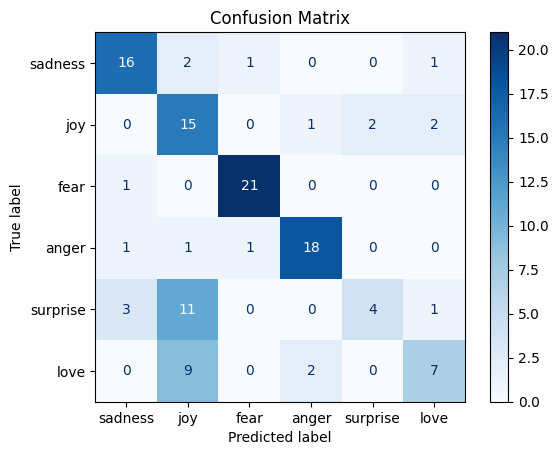

In [4]:
#visualize the confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


##Changed Model (32 batch)

In [14]:
import pandas as pd

# Load test.txt
test_file_path = "/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Testset.txt"

# Read the file into a DataFrame
test_data = pd.read_csv(test_file_path, sep=';', header=None, names=['text', 'label'])

# Map labels to numeric values (ensure this matches your training label mapping)
label_mapping = {
    'sadness': 0,
    'joy': 1,
    'fear': 2,
    'anger': 3,
    'surprise': 4,
    'love': 5
}
test_data['label'] = test_data['label'].map(label_mapping)

from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned")

# Tokenize the test text
test_encodings = tokenizer(
    test_data['text'].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

import torch

class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

test_dataset = CustomTestDataset(test_encodings, test_data['label'].tolist())

from transformers import AutoModelForSequenceClassification, Trainer

# Load the fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/IAT/IAT_360/FInalProject/Fine_tuned_Model_with_change/tweet_eval_finetuned")

# Define the Trainer with the model
trainer = Trainer(
    model=model,
    tokenizer=tokenizer
)

# Evaluate the model on the test dataset
results = trainer.evaluate(eval_dataset=test_dataset)

# Print the evaluation metrics
print("Evaluation Metrics:")
for metric, value in results.items():
    if metric.startswith("eval_"):
        print(f"{metric[5:]}: {value:.4f}")

<ipython-input-14-f3e905eaf08d>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation Metrics:
loss: 1.3032
model_preparation_time: 0.0091
runtime: 15.4862
samples_per_second: 7.7490
steps_per_second: 0.9690


Predict the sentiment for each sentence in the test file:

In [15]:
# Get predictions
predictions = trainer.predict(test_dataset)
logits, labels = predictions.predictions, predictions.label_ids
predicted_labels = logits.argmax(axis=-1)

# Map numeric predictions back to their labels
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
test_data['predicted_label'] = [reverse_label_mapping[label] for label in predicted_labels]

# Display some predictions
print(test_data[['text', 'label', 'predicted_label']].head())

                                                text  label predicted_label
0  Just got a surprise promotion I NEVER saw coming!      4             joy
1  Another birthday alone. Wondering if I'll ever...      0             joy
2  Politicians continue to fail us. WHEN WILL THI...      3         sadness
3  Medical test results coming in. Anxiety is thr...      2            fear
4      Married my best friend today. Soulmate found!      5            love


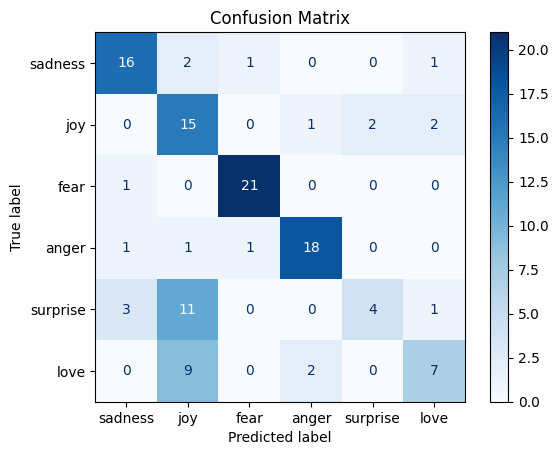

In [16]:
#visualize the confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
